# Purcell's Swimmer


In this notebook we will make a self-propelling Purcell Swimmer and dip it in a highly viscous fluid.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style("whitegrid")
from mpl_toolkits.mplot3d import axes3d
from itertools import product
plt.rcParams["animation.html"] = "jshtml"
from celluloid import Camera
import stokeslets as slts
import purcell as pur

In [2]:
figfile = "figs/"

## 1. Geometry

We need to define the position of the rods and the motors. Let's construct the swimmer with 3 rigid rods and place the end points of the rod in the $S_1$ configuration. The rod is parametrised by $\eta$ and $\phi$.

In [3]:
et = 0.5
ph = np.pi/6
size = 0.5

In [4]:
s = np.zeros([4,3]);
s[1,0:2] = np.array([-size/2,0]) #motor 1
s[2,0:2] = np.array([size/2,0]) #motor 2
s[0,0:2] = np.array([-size*et*np.cos(ph)-size/2,size*et*np.sin(ph)]) #arm 1
s[3,0:2] = np.array([size*et*np.cos(ph)+size/2,size*et*np.sin(ph)]) #arm 2
r = np.array([1,2]) #motor specifications

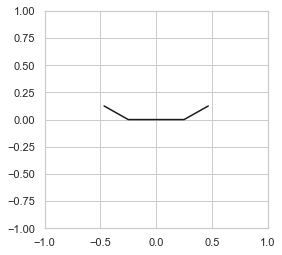

In [5]:
plt.figure(figsize=(4,4))
plt.plot(s.T[0],s.T[1],'k-')
plt.xlim(-1,1); plt.ylim(-1,1);

## 2. Dynamics

Define the time vector.

In [6]:
dt = 0.01
T = 16
tim = np.arange(0,T,dt)

Let's define $\tau_1 = [0,0,q_1(t)]$ and $\tau_2 = [0,0,q_2(t)]$.

In [7]:
tau = np.array([np.zeros(np.shape(tim)+(3,))]*np.size(r))

Since a Purcell Stroke is given by a constant difference between the torques exerted by the two motors, we can define parameters $P$ and $f$ where $P = |q_2(0)|$ and $f = \dfrac{|q_2(0)|}{|q_1(0)|}$ for a set of values of which we should get a Purcell stroke.

In [8]:
P = 0.45 #maximum power
f = 0.2 #fractional torque of the non-rotating arm
tau = pur.stroke_input(P,f,tim,r,strokes=2)

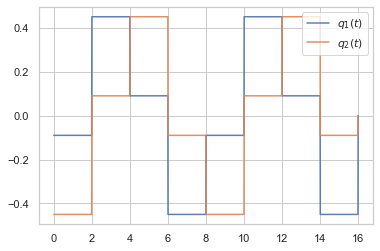

In [9]:
plt.plot(tim,tau[0,:,-1],'-',alpha=0.9);
plt.plot(tim,tau[1,:,-1],'-',alpha=0.9);
plt.legend(["$q_1 (t)$","$q_2 (t)$"],loc="upper right");

## 3. It Swims!

In [10]:
R = slts.mesher()

In [11]:
_,pswimmer = slts.evolve(tau,tim,R,r,s,k=100,e=0.3)

In [12]:
fig = plt.figure(figsize = (4.5,4.5))
plt.xlim(-1,1); plt.ylim(-1,1)
camera = Camera(fig)
for i in range(0,np.shape(pswimmer)[0],10):
    plt.plot(pswimmer[i].T[0],pswimmer[i].T[1],'k-', linewidth=2, alpha=0.5, label='_nolegend_')
    plt.plot(np.mean(pswimmer[i].T[0]),np.mean(pswimmer[i].T[1]),'ro', linewidth=2, alpha=0.5)
    camera.snap()
plt.legend(["CoM"])
plt.close()

In [13]:
animation = camera.animate()
animation.save(figfile+"purcell_swimmer.gif",writer = 'imagemagick',fps = 20,dpi=300)
animation

## 4. Purcell Strokes
We can try finding the torque difference required for a Purcell stroke by trial and error, but it would be easier to sample different $P$ and $f$ values and see which combination corresponds to a Purcell stroke.

First, let's determine the angular velocity difference between the ends of one arm when the other arm is moving. Let's call this $\omega$. Purcell strokes should have $\omega = 0$.

In [14]:
pur.omega(tau,pswimmer)

2.119730277470682e-05

Second, let's determine the difference between the magnitude of the arm angle after one stroke and the starting angle $\phi$. For a Purcell stroke, this value, which we call $\Delta\phi_0$, should also be equal to $0$.

In [15]:
pur.delphinought(tau,pswimmer,ph)

0.0062204023345048265

Now, we can try sampling over the parameter space to see which values of $P$ and $f$ minimize a _stroke function_ defined as $s(\omega,\Delta\phi_0) = \dfrac{\omega}{\max{(\omega})}+\dfrac{\Delta\phi_0}{\max{(\Delta\phi_0})}$

In [16]:
et = 0.5 #eta value
ph = np.pi/6 #phi value

P_vec = np.arange(0.35,0.55,0.02) #range of P values
f_vec = np.arange(0.15,0.26,0.01) #range of f values
Pm,fm = np.meshgrid(P_vec,f_vec,indexing='ij')

omega = np.zeros(np.shape(Pm))
delphinought = np.zeros(np.shape(Pm))

for i,P in enumerate(P_vec):
    for j,f in enumerate(f_vec):
        s,r,tim = pur.init(et,ph,T=8)
        tau = pur.stroke_input(P,f,tim,r,strokes=1)
        R = slts.mesher()
        try:
            _,pswimmer = slts.evolve(tau,tim,R,r,s,k=100,e=0.3)
            omega[i,j] = pur.omega(tau,pswimmer)
            delphinought[i,j] = pur.delphinought(tau,pswimmer,ph)
        except ValueError: #sometimes the swimmer can swim out of frame
            omega[i,j] = None
            delphinought[i,j] = None
    print(round((i+1)/(np.size(P_vec))*100,2),"%") #progress

9.09 %
18.18 %
27.27 %
36.36 %
45.45 %
54.55 %
63.64 %
72.73 %
81.82 %
90.91 %
100.0 %


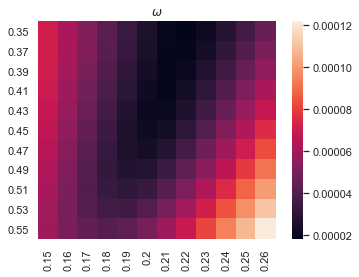

In [17]:
plt.title("$\omega$")
sns.heatmap(omega,square=True,xticklabels=np.round(f_vec,2),yticklabels=np.round(P_vec,2));

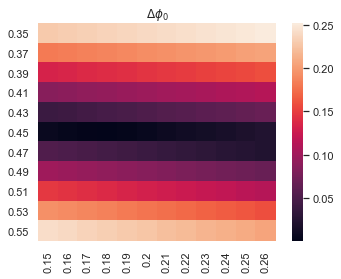

In [18]:
plt.title("$\Delta\phi_0$")
sns.heatmap(delphinought,square=True,xticklabels=np.round(f_vec,2),yticklabels=np.round(P_vec,2));

Note that $\Delta\phi_0$ does not vary much with the value of $f$.

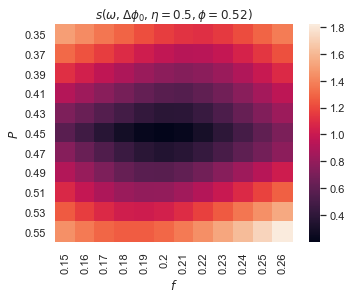

In [19]:
plt.title("$s(\omega,\Delta\phi_0,\eta="+str(round(et,1))+",\phi="+str(round(ph,2))+")$")
sf = pur.stroke_function(omega,delphinought)
sns.heatmap(sf,square=True,xticklabels=np.round(f_vec,2),yticklabels=np.round(P_vec,2));
plt.ylabel("$P$"); plt.xlabel("$f$")
plt.savefig(figfile+"stroke_function_30_0.5.png",dpi=300,bbox_inches="tight")

The values of $P$ and $f$ which correspond to the minima of $s(\omega,\Delta\phi_0)$ correspond to the Purcell stroke for $\eta$ and $\phi$.

In [20]:
minima = np.where(sf==np.min(sf))
print("P:",np.round(Pm[minima][0],2),"f:",np.round(fm[minima][0],2))

P: 0.45 f: 0.2
